In [17]:
import pandas as pd

data_train = pd.read_csv('../input/train.csv')
data_test = pd.read_csv('../input/test.csv')

In [18]:
# 提交文件的时候使用
passenger_id = data_test.PassengerId

In [19]:
# 训练模型的时候，要使用到 target
y = data_train['Survived']
del data_train['Survived']

特征工程，封装成函数。

In [20]:
def feature_preprocessing(data):
    # 性别
    data['Sex'] = data['Sex'].map(lambda x: 1 if x == 'male' else 0)

    # 缺失值填充
    data['Embarked'] = data['Embarked'].fillna(
        data['Embarked'].mode().values[0])

    # Fare 船票价格，使用平均数填充
    data['Fare'] = data['Fare'].fillna(data['Fare'].mean())

    Pclass_dummies = pd.get_dummies(data['Pclass'], prefix='Pclass')
    Embarked_dummies = pd.get_dummies(data['Embarked'], prefix='Embarked')

    # 丢弃姓名、客舱 Cabin 、船票信息 Ticket
    data.drop(
        columns=['Cabin', 'Ticket', 'Pclass', 'Embarked', 'PassengerId'],
        inplace=True)

    data = pd.concat([data, Pclass_dummies, Embarked_dummies], axis=1)
    return data


data_train = feature_preprocessing(data_train)
data_test = feature_preprocessing(data_test)

In [21]:
data_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
Name          891 non-null object
Sex           891 non-null int64
Age           714 non-null float64
SibSp         891 non-null int64
Parch         891 non-null int64
Fare          891 non-null float64
Pclass_1      891 non-null uint8
Pclass_2      891 non-null uint8
Pclass_3      891 non-null uint8
Embarked_C    891 non-null uint8
Embarked_Q    891 non-null uint8
Embarked_S    891 non-null uint8
dtypes: float64(2), int64(3), object(1), uint8(6)
memory usage: 47.1+ KB


In [22]:
data_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 418 entries, 0 to 417
Data columns (total 12 columns):
Name          418 non-null object
Sex           418 non-null int64
Age           332 non-null float64
SibSp         418 non-null int64
Parch         418 non-null int64
Fare          418 non-null float64
Pclass_1      418 non-null uint8
Pclass_2      418 non-null uint8
Pclass_3      418 non-null uint8
Embarked_C    418 non-null uint8
Embarked_Q    418 non-null uint8
Embarked_S    418 non-null uint8
dtypes: float64(2), int64(3), object(1), uint8(6)
memory usage: 22.1+ KB


训练数据集和测试数据集各自建立 `RandomForestRegressor` 填充 Age 缺失值。

In [23]:
from sklearn.ensemble import RandomForestRegressor


def predict_age_by_rfr(data):

    columns = data.columns
    cols = columns.tolist()
    if 'Survived' in cols:
        cols.remove('Survived')
    cols.remove('Name')
    cols.remove('Age')
    X_train_for_age = data.loc[data['Age'].notnull(), cols].values
    y_train_for_age = data.loc[data['Age'].notnull(), 'Age'].values

    rfr = RandomForestRegressor(random_state=666, n_estimators=100)
    rfr.fit(X_train_for_age, y_train_for_age)

    X_test_for_age = data.loc[data['Age'].isnull(), cols].values
    y_pred_for_age = rfr.predict(X_test_for_age)

    data.loc[data['Age'].isnull(), 'Age'] = y_pred_for_age


predict_age_by_rfr(data_train)
predict_age_by_rfr(data_test)

## 从姓名中抽取特征 Title

In [24]:
def feature_extract_Title(data):

    data['Title'] = data['Name'].map(
        lambda x: x.split(',')[1].split('.')[0].strip())
    Title_Dictionary = {
        "Mr": "Mr",
        "Mrs": "Mrs",
        "Miss": "Miss",
        "Master": "Master",
        "Don": "Royalty",
        "Rev": "Officer",
        "Dr": "Officer",
        "Mme": "Mrs",
        "Ms": "Mrs",
        "Major": "Officer",
        "Lady": "Royalty",
        "Sir": "Royalty",
        "Mlle": "Miss",
        "Col": "Officer",
        "Capt": "Officer",
        "the Countess": "Royalty",
        "Jonkheer": "Royalty",
        "Dona": 'Mrs'
    }
    data['Title'] = data['Title'].map(Title_Dictionary)

    Title_dummies = pd.get_dummies(data['Title'], prefix='Title')
    data = pd.concat([data, Title_dummies], axis=1)
    # 丢弃姓名、客舱 Cabin 、船票信息 Ticket
    data.drop(columns=['Name', 'Title'], inplace=True)
    return data


combined_data = pd.concat([data_train, data_test], axis=0, sort=True)
combined_data = feature_extract_Title(combined_data)
data_train = combined_data.iloc[:data_train.shape[0], :]
data_test = combined_data.iloc[data_train.shape[0]:, :]

In [25]:
data_train.shape

(891, 17)

In [26]:
data_test.shape

(418, 17)

In [27]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    data_train, y, test_size=0.2, random_state=666)

## 模型训练

In [34]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import GradientBoostingClassifier
from xgboost import XGBClassifier

dt = DecisionTreeClassifier(random_state=666)
lr = LogisticRegression(solver='newton-cg')
rfc = RandomForestClassifier(random_state=666, n_estimators=100)
svc = SVC(kernel='rbf', gamma='scale')
ada = AdaBoostClassifier()
gbc = GradientBoostingClassifier()
xgb = XGBClassifier()

models = [('DecisionTreeClassifier', dt), ('LogisticRegression', lr),
          ('RandomForestClassifier', rfc), ('svc', svc),
          ('AdaBoostClassifier', ada), ('GradientBoostingClassifier',
                                        gbc), ('XBClassifier', xgb)]


def predict_by_different_models(models):
    res = dict()
    for model in models:
        model_name = model[0]
        clf = model[1]
        clf.fit(X_train, y_train)
        train_score = clf.score(X_train, y_train)
        test_score = clf.score(X_test, y_test)
        res[model_name] = {
            'train_score': train_score,
            'test_score': test_score
        }
    return res


res = predict_by_different_models(models)

In [35]:
res = pd.DataFrame(res).T
res.reindex(columns=['train_score', 'test_score'])

,train_score,test_score
DecisionTreeClassifier,0.983146,0.787709
LogisticRegression,0.842697,0.793296
RandomForestClassifier,0.983146,0.832402
svc,0.691011,0.670391
AdaBoostClassifier,0.846910,0.793296
GradientBoostingClassifier,0.901685,0.821229
XBClassifier,0.886236,0.826816


## 特征选择

In [48]:
np.sort(rfc.feature_importances_)

array([0.00088398, 0.0088847 , 0.0088995 , 0.00997205, 0.01091166,
       0.01383765, 0.01408951, 0.02414306, 0.02948171, 0.03645224,
       0.04218361, 0.04814861, 0.05403489, 0.10296689, 0.1267766 ,
       0.22248921, 0.24584414])

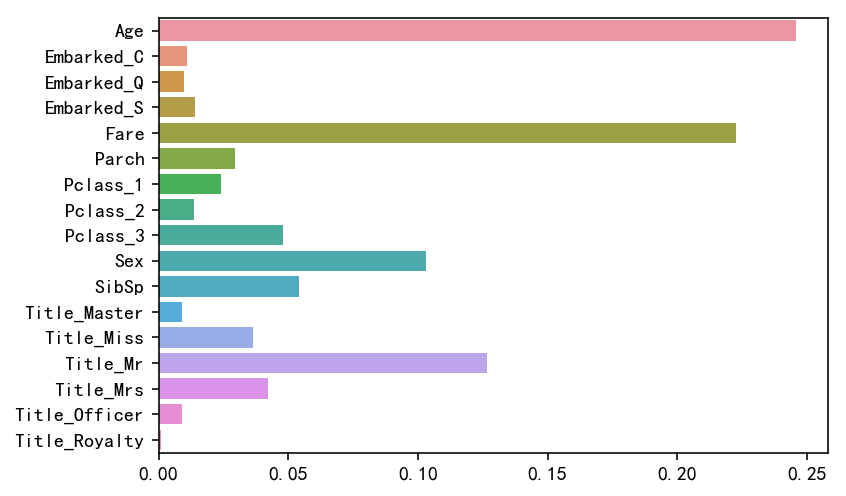

In [44]:
import seaborn as sns

sns.barplot(y=X_train.columns, x=rfc.feature_importances_, orient='h')
plt.show()

In [49]:
# 留下 8 个特征
importance_feature = X_train.columns[rfc.feature_importances_ >= 0.03]
importance_feature

Index(['Age', 'Fare', 'Pclass_3', 'Sex', 'SibSp', 'Title_Miss', 'Title_Mr',
       'Title_Mrs'],
      dtype='object')

In [51]:
%%time
from sklearn.model_selection import GridSearchCV

params = {
    'max_depth': list(range(2, 7)),
    'n_estimators': list(range(100, 1100, 200)),
    'learning_rate': [0.05, 0.1, 0.25, 0.5, 1.0]
}

xgbc = XGBClassifier()

gs = GridSearchCV(xgbc, params, n_jobs=-1, cv=5, verbose=1)

gs.fit(X_train[importance_feature], y_train)

Fitting 5 folds for each of 125 candidates, totalling 625 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done 124 tasks      | elapsed:    4.5s
[Parallel(n_jobs=-1)]: Done 350 tasks      | elapsed:   11.4s
[Parallel(n_jobs=-1)]: Done 600 tasks      | elapsed:   19.9s


CPU times: user 2.35 s, sys: 89.4 ms, total: 2.44 s
Wall time: 21.1 s


[Parallel(n_jobs=-1)]: Done 625 out of 625 | elapsed:   21.1s finished


In [52]:
gs.best_params_

{'learning_rate': 0.1, 'max_depth': 4, 'n_estimators': 100}

In [53]:
gs.best_score_

0.8356741573033708

In [54]:
gs.best_estimator_.score(X_test[importance_feature], y_test)

0.7988826815642458

得到最佳超参数以后，再放到全部训练集上训练一次。

+ `GridSearchCV` 可以设置 `refit=True`。

In [55]:
xgbc_best = XGBClassifier(learning_rate=0.1, max_depth=4, n_estimators=100)
xgbc_best.fit(data_train[importance_feature], y)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=4, min_child_weight=1, missing=None, n_estimators=100,
       n_jobs=1, nthread=None, objective='binary:logistic', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=True, subsample=1)

In [56]:
y_pred = xgbc_best.predict(data_test[importance_feature])

In [58]:
result = pd.DataFrame({'PassengerId': passenger_id, 'Survived': y_pred})
result.to_csv('../output/xgbc_submission.csv', index=None)